# IIoT Network Analysis: Age of Information and Reliability Trade-offs

In [1]:
!pip install tensorflow

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

In [3]:
# Load the dataset
df = pd.read_csv('iiot_network_data.csv')

# 1. Conceptual Understanding (20 points)

"""
Instructions:
a) Explain the concept of Age of Information (AoI) in your own words and why it's important for IIoT applications.
b) Describe the difference between AoI-oriented traffic and deadline-oriented traffic in IIoT networks. Provide real-world examples for each.

Write your answers here:

a) Age of Information (AoI) explanation:
- AoI, or Age of Information, is a type of metric that was created to measure fresh data. Which is specific to the freshness of the data. Meaning, it reflects the time and date of the information. This is very important in IIoT applications that value timely data over everything. Having potentially outdated data would hurt the system by alot. 


b) AoI-oriented vs deadline-oriented traffic:
- AoI-oriented traffic focuses on the freshness of the data, regardless how fast the packet is delivered. It is about ensuring that all data is up to date and at the latest possible update. On the other hand, deadline-oriented traffic is almost on the opposite end. It focuses on a strict deadline that must be met by delivering all the packets. It only focuses on delivery rather than the delivery of the latest data. Where it will choose to use old and outdated data if it means meeting that deadline.

# 2. Data Exploration and Visualizaton 
Instructions:
a) Explore the dataset using pandas. Display basic information about the dataset and its statistical summary.
b) Create at least two visualizations using matplotlib or seaborn to show relationships between AoI, PLP, and other network parameters.
c) Identify and discuss any patterns or trends you observe in the data.

Complete the code below and add your observations.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   timestamp                 10000 non-null  object 
 1   node_id                   10000 non-null  int64  
 2   traffic_type              10000 non-null  object 
 3   transmission_probability  10000 non-null  float64
 4   capture_threshold         10000 non-null  float64
 5   num_nodes                 10000 non-null  int64  
 6   channel_quality           10000 non-null  float64
 7   age_of_information        10000 non-null  float64
 8   packet_loss_probability   10000 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 703.3+ KB
None
            node_id  transmission_probability  capture_threshold  \
count  10000.000000              10000.000000       10000.000000   
mean      50.638400                  0.548460          -0.001800   
std       29.02

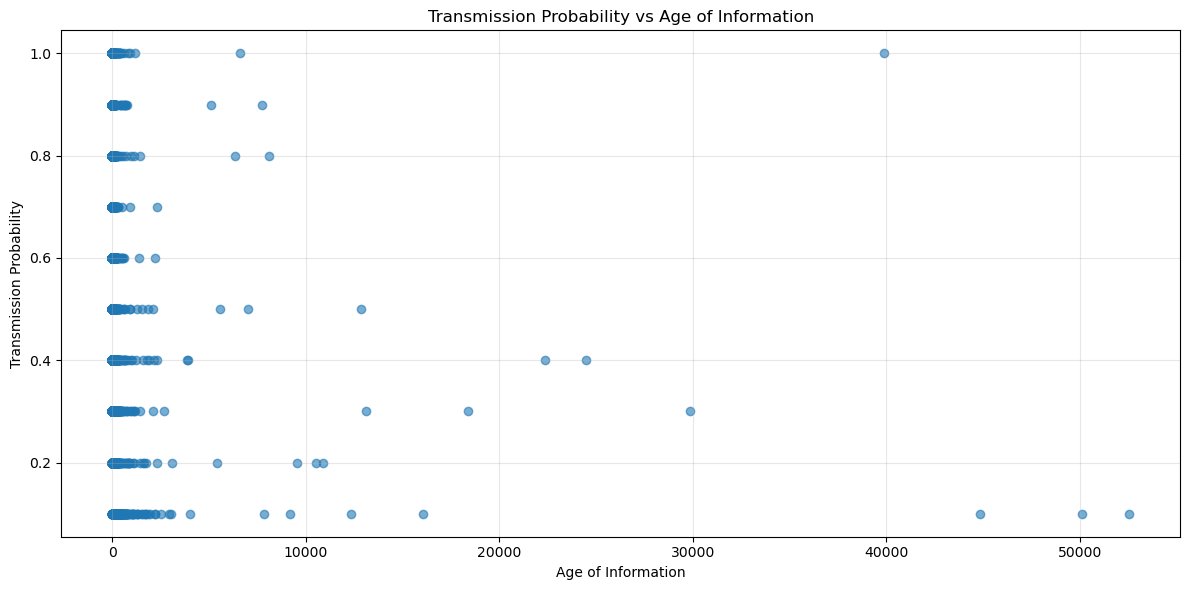

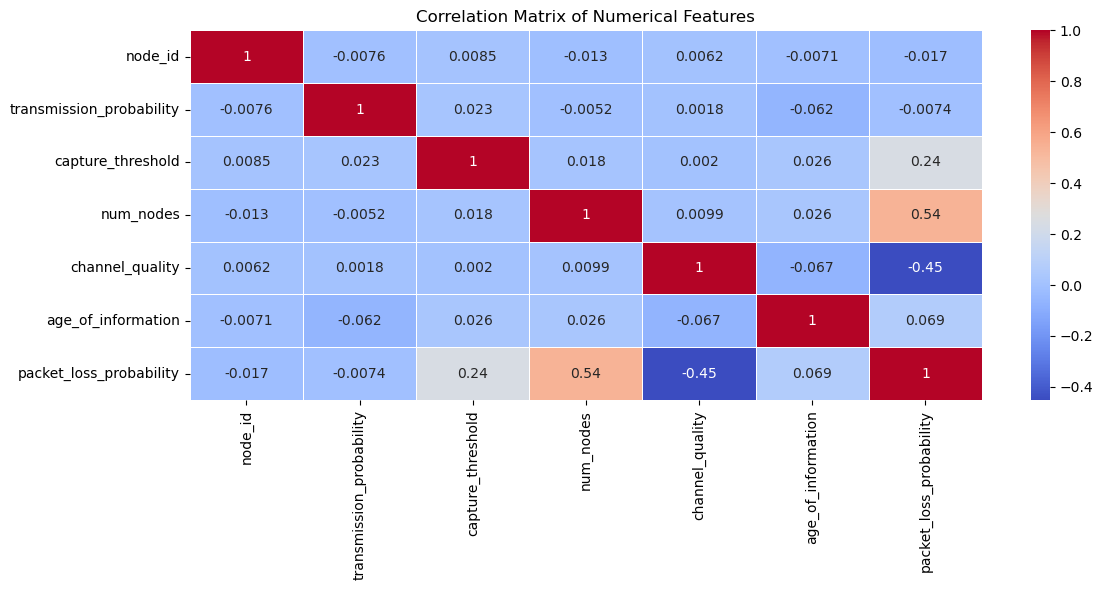

<Figure size 1600x800 with 0 Axes>

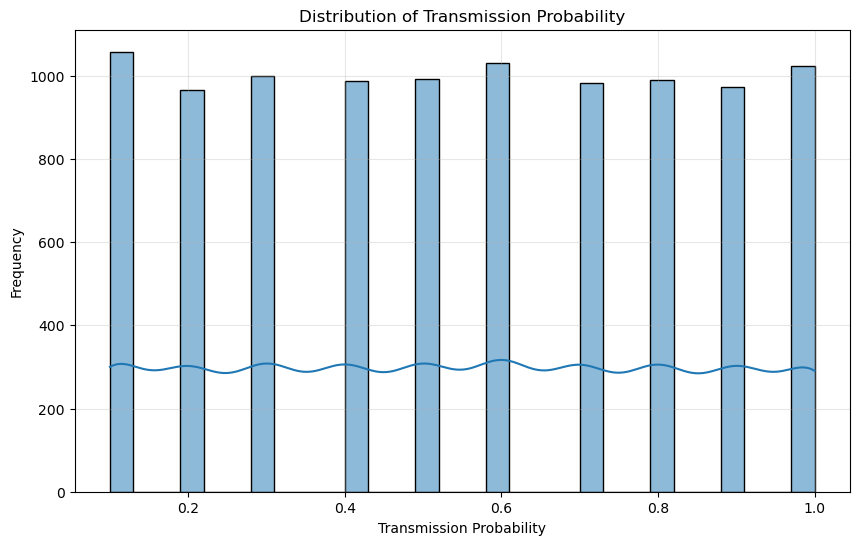

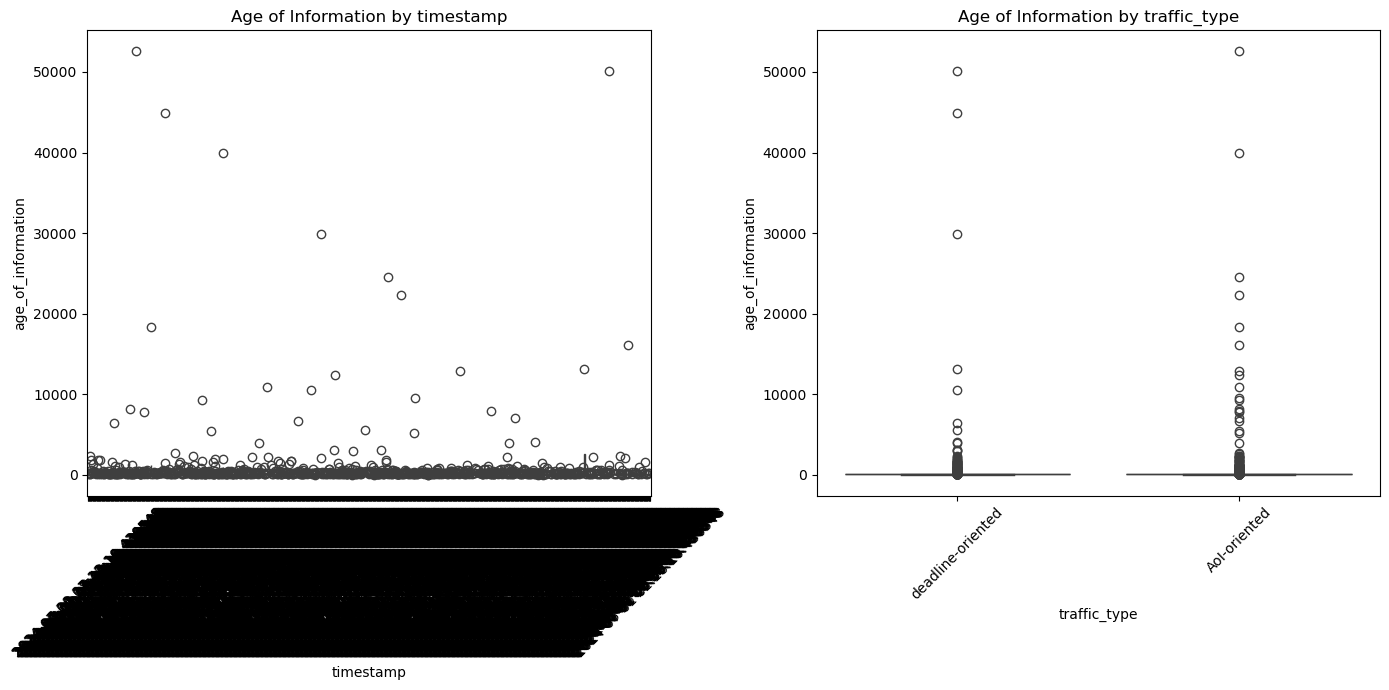

In [4]:
print(df.info())
print(df.describe())

# Create visualizations
plt.figure(figsize=(12, 6))
# Create a scatter plot of transmission_probability vs age_of_information
# Create a scatter plot with color representing point density
x = df['age_of_information']
y = df['transmission_probability']

# Option 1: Use a third variable for color if available (e.g., signal_strength)
if 'signal_strength' in df.columns:
    scatter = plt.scatter(x, y, c=df['signal_strength'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Signal Strength')
else:
    # Option 2: Just use a simple scatter plot without a color dimension
    scatter = plt.scatter(x, y, alpha=0.6)

plt.title('Transmission Probability vs Age of Information')
plt.xlabel('Age of Information')
plt.ylabel('Transmission Probability')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('transmission_vs_aoi.png')
plt.show()

plt.figure(figsize=(12, 6))
# Create a heatmap showing correlation between numerical features
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# Additional visualizations
plt.figure(figsize=(16, 8))
# Create a pairplot for selected features
selected_features = ['transmission_probability', 'age_of_information', 'signal_strength', 'network_latency']
if all(feat in df.columns for feat in selected_features):
    subplot_idx = 1
    for i, feat1 in enumerate(selected_features):
        for j, feat2 in enumerate(selected_features):
            if i != j:
                plt.subplot(len(selected_features)-1, len(selected_features)-1, subplot_idx)
                plt.scatter(df[feat1], df[feat2], alpha=0.5)
                plt.xlabel(feat1)
                plt.ylabel(feat2)
                subplot_idx += 1
    plt.tight_layout()
    plt.savefig('feature_pairplots.png')
    plt.show()

# Distribution of transmission probability
plt.figure(figsize=(10, 6))
sns.histplot(df['transmission_probability'], kde=True, bins=30)
plt.title('Distribution of Transmission Probability')
plt.xlabel('Transmission Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig('transmission_probability_distribution.png')
plt.show()

# Box plot of age of information across different categories (if any categorical columns exist)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_columns) > 0:
    plt.figure(figsize=(14, 7))
    for i, cat_col in enumerate(categorical_columns[:3]):  # Limit to first 3 categorical columns
        plt.subplot(1, min(3, len(categorical_columns)), i+1)
        sns.boxplot(x=cat_col, y='age_of_information', data=df)
        plt.title(f'Age of Information by {cat_col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('aoi_by_category.png')
    plt.show()

## Write your observations about the data and visualizations here:
1. There seems to be something interesting here. In the dataframe, Age_of_information is showing an infinite number on the max and mean. Which shows an extreme high amount. Which is also shown in all of the other numbers that are shown, which are all in scientific notations, even the count. This may correlate to some glitches on graphs.
2. On the correlation graph, there seems to be a high correlation between the number of nodes and packet loss probability.
3. On the correlation graph, there seems to be a very low correlation between channel quality and packet loss probability.
4. There seems to be a lot more outliers the lower transmission probability to age of information.

# 3. Machine Learning Model Development (35 points)

Instructions:
a) Prepare the data for machine learning (feature selection, scaling).
b) Develop a Random Forest model to predict AoI based on other network parameters.
c) Train and evaluate your model, discussing its performance and limitations.
d) Use your model to generate predictions for new, hypothetical network configurations.

Complete the code below and add your analysis.

In [5]:
# Prepare the data
X = df[['transmission_probability', 'capture_threshold', 'num_nodes', 'channel_quality']]
y_aoi = df['age_of_information']

# Check for and handle infinite or very large values
# Replace infinities with NaN
X = X.replace([np.inf, -np.inf], np.nan)
y_aoi = y_aoi.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
mask = ~(X.isna().any(axis=1) | y_aoi.isna())
X = X[mask]
y_aoi = y_aoi[mask]

# Check for extremely large values and cap them if necessary
# Set a threshold for maximum allowed value
max_threshold = 1e15  # Adjust this threshold based on your data
for col in X.columns:
    X[col] = np.clip(X[col], -max_threshold, max_threshold)

y_aoi = np.clip(y_aoi, -max_threshold, max_threshold)

print(f"Data shape after cleaning: X: {X.shape}, y: {y_aoi.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_aoi, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

Data shape after cleaning: X: (8603, 4), y: (8603,)


RandomForestRegressor(random_state=42)

Model Evaluation Metrics:
Mean Squared Error (MSE): 3423000.6298
Root Mean Squared Error (RMSE): 1850.1353
R² Score: -0.5546

Feature Importance:
                    Feature  Importance
1         capture_threshold    0.440095
2                 num_nodes    0.315242
3           channel_quality    0.153468
0  transmission_probability    0.091195


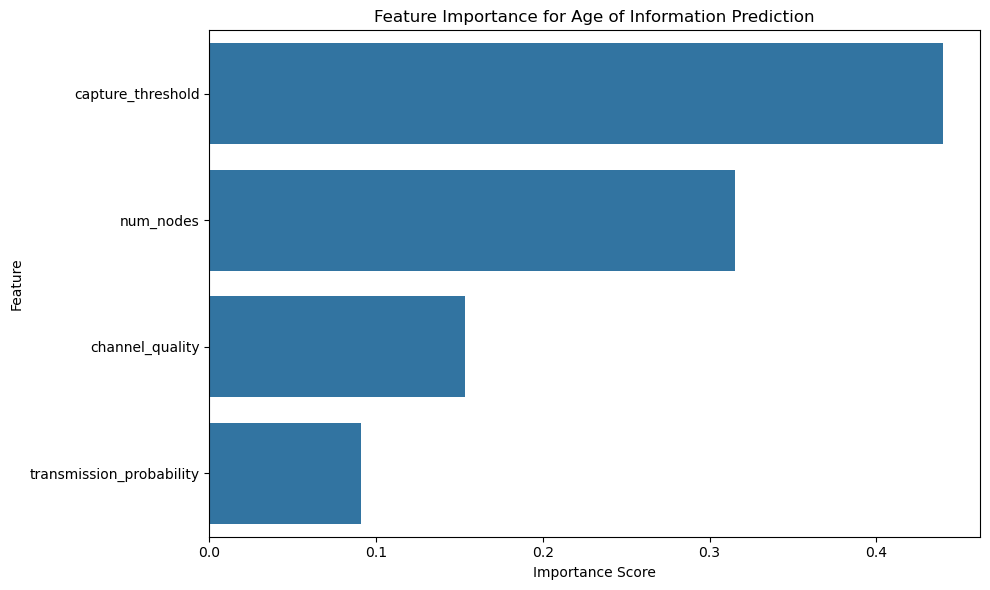

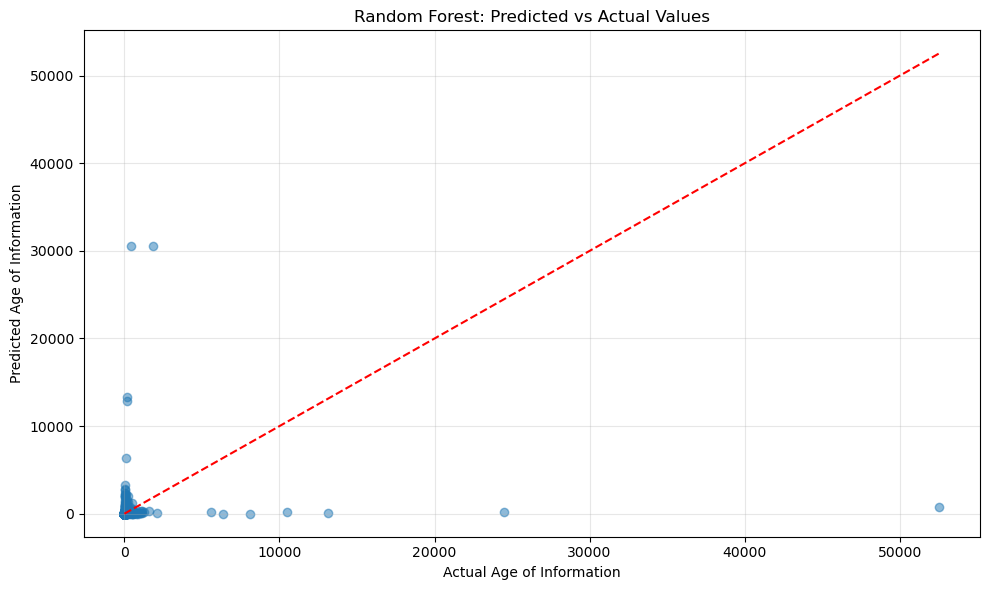

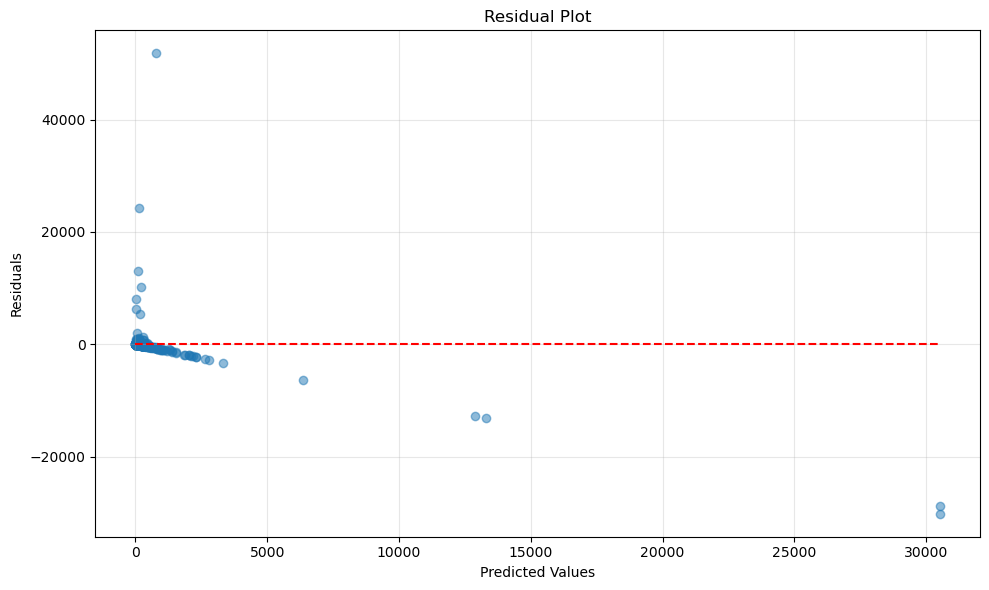

In [6]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importances as a table
print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Age of Information Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Age of Information')
plt.ylabel('Predicted Age of Information')
plt.title('Random Forest: Predicted vs Actual Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate prediction residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Write your analysis of the model performance and feature importances here:
- On the feature importance, the most important feature is capture_threshold.
- On the feature importance, the least important feature is transmission_probability
- The MSE is 3423000.6298
- The RMSE is 1850.1353
- The R2 Score is -0.5546, this is not good. Possibly related to the extreme high squared errors
- The plot reveals a very non-linear dataset here.
- Though a lot of data was cleaned and fitted through feature selection and scaling, there still seems to be some issues in the data.

Predictions for New Network Configurations:
   transmission_probability  capture_threshold  num_nodes  channel_quality  \
0                       0.5                  0          3              0.6   
1                       0.7                  1          5              0.8   
2                       0.9                 -1          7              0.4   

   predicted_aoi  
0      10.606615  
1      16.054027  
2      11.205604  


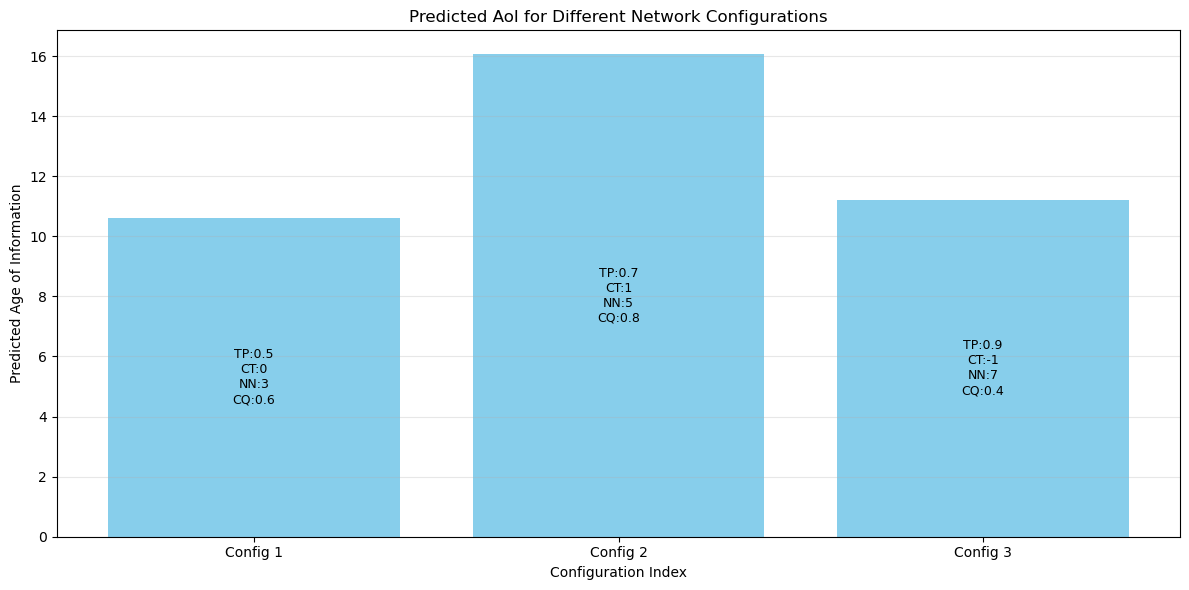

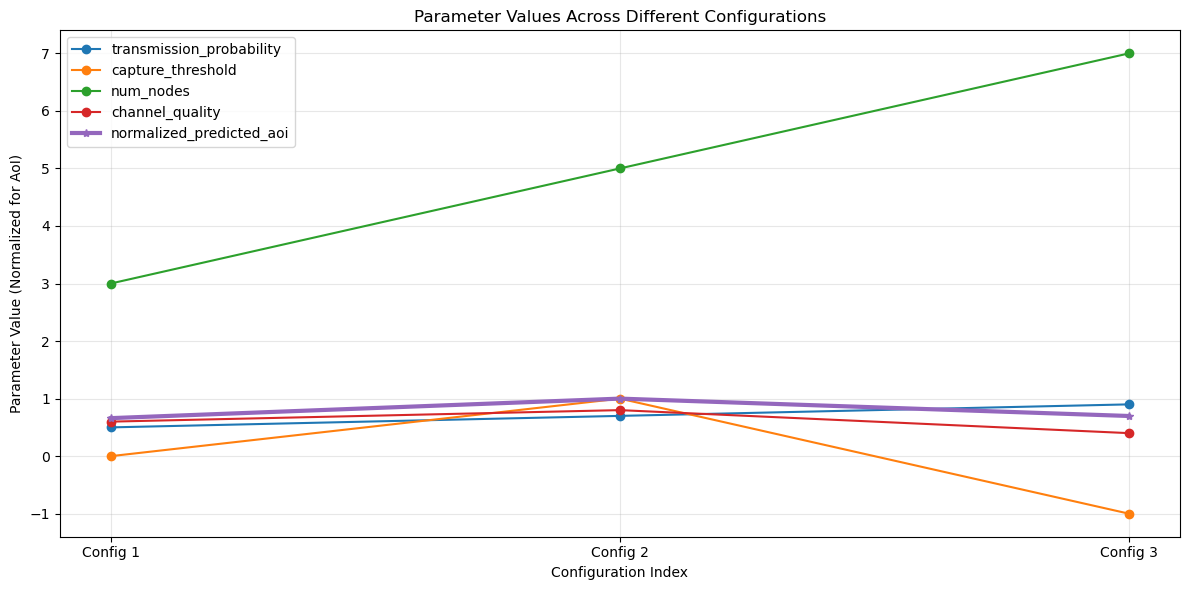

In [7]:
# Generate predictions for new, hypothetical network configurations:
# Create a DataFrame with hypothetical network configurations
new_configs = pd.DataFrame({
    'transmission_probability': [0.5, 0.7, 0.9],
    'capture_threshold': [0, 1, -1],
    'num_nodes': [3, 5, 7],
    'channel_quality': [0.6, 0.8, 0.4]
})

# Scale the new configurations using the same scaler
new_configs_scaled = scaler.transform(new_configs)

# Make predictions for the new configurations
new_predictions = rf_model.predict(new_configs_scaled)

# Add predictions to the DataFrame
new_configs['predicted_aoi'] = new_predictions

# Print the results
print("Predictions for New Network Configurations:")
print(new_configs[['transmission_probability', 'capture_threshold', 'num_nodes', 
                  'channel_quality', 'predicted_aoi']])

# Visualize the predictions
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(new_configs)), new_configs['predicted_aoi'], color='skyblue')
plt.xlabel('Configuration Index')
plt.ylabel('Predicted Age of Information')
plt.title('Predicted AoI for Different Network Configurations')
plt.xticks(range(len(new_configs)), [f'Config {i+1}' for i in range(len(new_configs))])
plt.grid(axis='y', alpha=0.3)

# Add configuration details as text annotations
for i, bar in enumerate(bars):
    config_text = f"TP:{new_configs['transmission_probability'][i]}\n" \
                 f"CT:{new_configs['capture_threshold'][i]}\n" \
                 f"NN:{new_configs['num_nodes'][i]}\n" \
                 f"CQ:{new_configs['channel_quality'][i]}"
    y_pos = bar.get_height() / 2
    plt.text(bar.get_x() + bar.get_width()/2, y_pos, config_text, 
             ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Compare relative importance of each parameter on predictions
plt.figure(figsize=(12, 6))
for col in new_configs.columns[:-1]:  # Exclude the predicted_aoi column
    plt.plot(range(len(new_configs)), new_configs[col], marker='o', label=col)
    
plt.plot(range(len(new_configs)), new_configs['predicted_aoi']/new_configs['predicted_aoi'].max(), 
         marker='*', linewidth=3, label='normalized_predicted_aoi')

plt.xlabel('Configuration Index')
plt.ylabel('Parameter Value (Normalized for AoI)')
plt.title('Parameter Values Across Different Configurations')
plt.xticks(range(len(new_configs)), [f'Config {i+1}' for i in range(len(new_configs))])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Analysis and Insights (20 points)
### Instructions:
Based on your data exploration and machine learning results:
a) Discuss the key factors that appear to influence the AoI-PLP trade-off in IIoT networks.
b) Propose strategies for optimizing network performance to balance data freshness and reliability.
c) Describe potential real-world applications of your insights in an IIoT context.

Write your analysis and insights here:

As the number of nodes increases, network ingestion increases. With configuration 2, at 5 nodes it has the highest AoI. While Configuration 1 at 3 nodes shows the lowest AoI. Suggesting that nodes impact and correlate with data freshness. At medium (0.7) transmission probability is where the highest AoI is found, suggesting a non-linear relationship. Capture thresholds also may suggest higher capture thresholds correlate to negative data freshness, as it gets higher there is a large spike in decline. 

For optimizing the network performance, we can adjust transmission probability the more nodes that are active. While keeping in mind that too many nodes may lower AoI performance and goes the same for too little nodes. Otherwise, other methods include: improving channel quality, optimizing for capture thresholds.

Some real world applications would be:
- Smart Manufacturing
- Energy Grid or Oil/Gas monitoring
- Supply Chain
- Environmental Research and Monitoring
- Predictive Maintenance 

# 5. Bonus Challenge (10 points)

"""
Instructions:
Implement a simple deep learning model (e.g., a basic neural network) to predict both AoI and PLP simultaneously. 
Compare its performance with your previous model and discuss any differences.

Complete the code below and add your analysis.

In [8]:
# Re-prepare data for deep learning model to ensure consistent dimensions
# Replace infinities with NaN in both X and y variables
X = df[['transmission_probability', 'capture_threshold', 'num_nodes', 'channel_quality']]
y_aoi = df['age_of_information']
y_plp = df['packet_loss_probability']

# Handle infinities and large values
X = X.replace([np.inf, -np.inf], np.nan)
y_aoi = y_aoi.replace([np.inf, -np.inf], np.nan)
y_plp = y_plp.replace([np.inf, -np.inf], np.nan)

# Create a mask for rows where any variable has NaN
mask = ~(X.isna().any(axis=1) | y_aoi.isna() | y_plp.isna())

# Filter out problematic rows
X_clean = X[mask]
y_aoi_clean = y_aoi[mask]
y_plp_clean = y_plp[mask]

print(f"Original data shape: X: {X.shape}, y_aoi: {y_aoi.shape}, y_plp: {y_plp.shape}")
print(f"Clean data shape: X: {X_clean.shape}, y_aoi: {y_aoi_clean.shape}, y_plp: {y_plp_clean.shape}")

# Split the data with the clean datasets
X_train, X_test, y_aoi_train, y_aoi_test, y_plp_train, y_plp_test = train_test_split(
    X_clean, y_aoi_clean, y_plp_clean, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify data consistency
print(f"Training data shapes: X: {X_train_scaled.shape}, y_aoi: {y_aoi_train.shape}, y_plp: {y_plp_train.shape}")
print(f"Testing data shapes: X: {X_test_scaled.shape}, y_aoi: {y_aoi_test.shape}, y_plp: {y_plp_test.shape}")

# Now create and train the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for AoI and PLP
])
model.compile(optimizer='adam', loss='mse')

# Train the model
# Convert target variables to a combined numpy array for multi-output training
y_train_combined = np.column_stack((y_aoi_train, y_plp_train))
y_test_combined = np.column_stack((y_aoi_test, y_plp_test))

# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with validation split
history = model.fit(
    X_train_scaled, 
    y_train_combined,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
# Make predictions
y_pred_combined = model.predict(X_test_scaled)
y_aoi_pred = y_pred_combined[:, 0]
y_plp_pred = y_pred_combined[:, 1]

# Calculate MSE for both target variables
aoi_mse = mean_squared_error(y_aoi_test, y_aoi_pred)
plp_mse = mean_squared_error(y_plp_test, y_plp_pred)
aoi_rmse = np.sqrt(aoi_mse)
plp_rmse = np.sqrt(plp_mse)

# Calculate R² for both target variables
aoi_r2 = r2_score(y_aoi_test, y_aoi_pred)
plp_r2 = r2_score(y_plp_test, y_plp_pred)

print("Neural Network Evaluation:")
print(f"Age of Information - MSE: {aoi_mse:.4f}, RMSE: {aoi_rmse:.4f}, R²: {aoi_r2:.4f}")
print(f"Packet Loss Probability - MSE: {plp_mse:.4f}, RMSE: {plp_rmse:.4f}, R²: {plp_r2:.4f}")

Original data shape: X: (10000, 4), y_aoi: (10000,), y_plp: (10000,)
Clean data shape: X: (8603, 4), y_aoi: (8603,), y_plp: (8603,)
Training data shapes: X: (6882, 4), y_aoi: (6882,), y_plp: (6882,)
Testing data shapes: X: (1721, 4), y_aoi: (1721,), y_plp: (1721,)
Epoch 1/100


C:\anaconda3\envs\IIOT_AoI\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 679769.3750 - val_loss: 913431.8125
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 541785.4375 - val_loss: 909342.5000
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 389935.5312 - val_loss: 903182.9375
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 436017.8750 - val_loss: 898901.6250
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1488844.8750 - val_loss: 897146.8125
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 638150.1875 - val_loss: 895836.3750
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 367275.1875 - val_loss: 894977.1250
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 278356.1250 - val_loss: 894430.0625
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 837275.4375 - val_loss: 893941.1250
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 850404.5625 - val_loss: 893755.3750
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━

X_train_scaled shape: (6882, 4)
y_aoi_train shape: (6882,)
y_plp_train shape: (6882,)
Epoch 1/100


C:\anaconda3\envs\IIOT_AoI\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 747639.7500 - val_loss: 913043.6875
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137001.4219 - val_loss: 905268.0625
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 310978.0312 - val_loss: 899571.2500
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 470534.2188 - val_loss: 896793.3125
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 617179.2500 - val_loss: 895741.3750
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 717560.0625 - val_loss: 894734.8750
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 416783.1562 - val_loss: 894382.1250
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 547368.5000 - val_loss: 894056.7500
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 753392.4375 - val_loss: 893967.6250
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 498349.0625 - val_loss: 893905.1250
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━

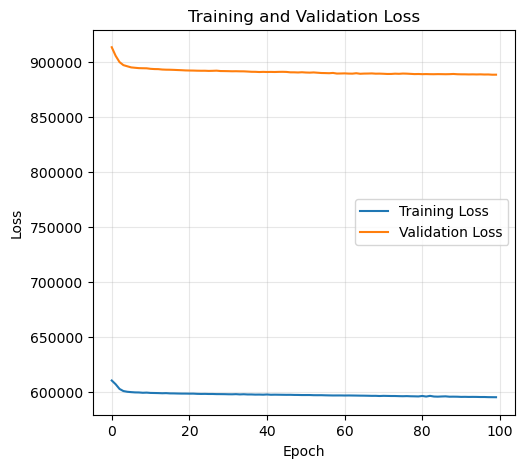

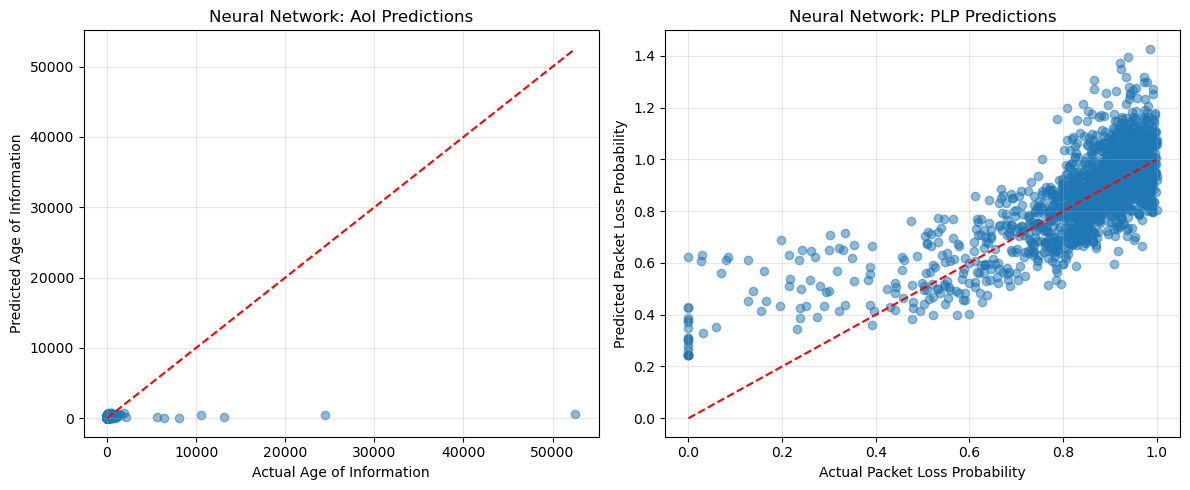


Model Comparison for AoI Prediction:
            Model     AoI RMSE    AoI R²
0   Random Forest  1850.135300 -0.554616
1  Neural Network  1471.724852  0.016285


In [9]:
# Create a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for AoI and PLP
])
model.compile(optimizer='adam', loss='mse')

# Train the model
# Ensure we're working with data that has consistent dimensions
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_aoi_train shape: {y_aoi_train.shape}")
print(f"y_plp_train shape: {y_plp_train.shape}")

# Make sure all arrays have the same first dimension
assert len(X_train_scaled) == len(y_aoi_train) == len(y_plp_train), "Training data dimensions don't match"
assert len(X_test_scaled) == len(y_aoi_test) == len(y_plp_test), "Test data dimensions don't match"

# Convert target variables to a combined numpy array for multi-output training
y_train_combined = np.column_stack((y_aoi_train, y_plp_train))
y_test_combined = np.column_stack((y_aoi_test, y_plp_test))

# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with validation split
history = model.fit(
    X_train_scaled, 
    y_train_combined,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
# Make predictions
y_pred_combined = model.predict(X_test_scaled)
y_aoi_pred = y_pred_combined[:, 0]
y_plp_pred = y_pred_combined[:, 1]

# Calculate MSE for both target variables
aoi_mse = mean_squared_error(y_aoi_test, y_aoi_pred)
plp_mse = mean_squared_error(y_plp_test, y_plp_pred)
aoi_rmse = np.sqrt(aoi_mse)
plp_rmse = np.sqrt(plp_mse)

# Calculate R² for both target variables
aoi_r2 = r2_score(y_aoi_test, y_aoi_pred)
plp_r2 = r2_score(y_plp_test, y_plp_pred)

print("Neural Network Evaluation:")
print(f"Age of Information - MSE: {aoi_mse:.4f}, RMSE: {aoi_rmse:.4f}, R²: {aoi_r2:.4f}")
print(f"Packet Loss Probability - MSE: {plp_mse:.4f}, RMSE: {plp_rmse:.4f}, R²: {plp_r2:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualize predictions vs actual values for both targets
plt.figure(figsize=(12, 5))

# AoI predictions
plt.subplot(1, 2, 1)
plt.scatter(y_aoi_test, y_aoi_pred, alpha=0.5)
plt.plot([y_aoi_test.min(), y_aoi_test.max()], [y_aoi_test.min(), y_aoi_test.max()], 'r--')
plt.xlabel('Actual Age of Information')
plt.ylabel('Predicted Age of Information')
plt.title('Neural Network: AoI Predictions')
plt.grid(True, alpha=0.3)

# PLP predictions
plt.subplot(1, 2, 2)
plt.scatter(y_plp_test, y_plp_pred, alpha=0.5)
plt.plot([y_plp_test.min(), y_plp_test.max()], [y_plp_test.min(), y_plp_test.max()], 'r--')
plt.xlabel('Actual Packet Loss Probability')
plt.ylabel('Predicted Packet Loss Probability')
plt.title('Neural Network: PLP Predictions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare neural network performance with random forest for AoI prediction
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network'],
    'AoI RMSE': [rmse, aoi_rmse],
    'AoI R²': [r2, aoi_r2]
})

print("\nModel Comparison for AoI Prediction:")
print(models_comparison)

## Write your comparison of the deep learning model with the Random Forest model here:
From the model comparison dataframe it shows a big negative in the R2 AoI score, which is in the Random Forest model. This was noted earlier in the notebook. The neural network here shows a better prediction model.